## Ejercicio 3

_Iris_ es el género de una planta herbácea con flores que se utilizan en decoración. Dentro de este género existen muy diversas especies, entre las que se han estudiado: _Iris setosa_, _Iris versicolor_ e _Iris virginica_ (ver Figura 2).

Estas tres especies pueden distinguirse según las dimensiones de sus pétalos y sépalos. Un grupo de investigadores ha recopilado la información correspondiente a las longitudes y anchos de los pétalos y sépalos de 50 plantas de cada especie. En el archivo `iris81_trn.csv` se encuentra el conjunto de entrenamiento, y en `iris81_tst.csv` el de prueba, generado a partir de estas mediciones (en cm), junto con un código binario que indica la clase de cada meustra (Especie) reconocida por el grupo de investigadores ([-1, -1, 1] = _setosa_, [-1, 1, -1] = _versicolor_, [1, -1, -1] = _virginica_).

Determine la estructura óptima de un perceptrón multicapa para resolver este problema. Explore cómo varía el desempeño al usar distintas tasas de aprendizaje, y para cada caso grafique las curvas de error cuadrático total y error de clasificación en función de las épocas de entrenamiento.

error de training: 0.07207207207207207


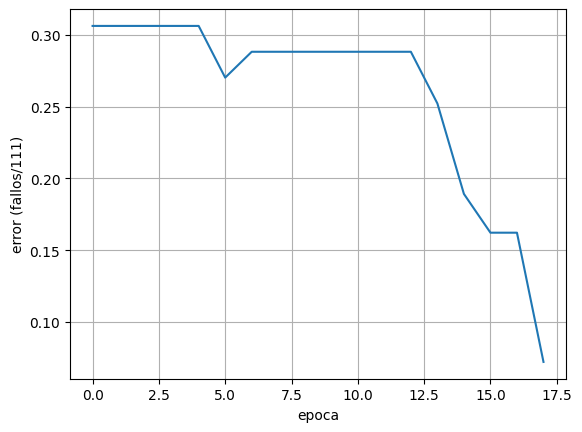

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PerceptronMulticapa

def cargarCSV(csvRelativePath, delimeter = ',') -> np.ndarray[any]:
    this_folder = os.path.abspath('') 
    fullPath = os.path.join(this_folder, csvRelativePath)
    return np.loadtxt(fullPath, dtype=float, delimiter=delimeter)

# ===== TRAINING =====
# leer archivos
trainFileXOR = cargarCSV('./data/iris81_trn.csv')
x = trainFileXOR[:,:-3]
yd = trainFileXOR[:,-3:]

NNXOR = PerceptronMulticapa.PerceptronMulticapa(
    cant_entradas=x.shape[1],
    capas=[2,3],
    max_epocas=100,
    tasa_aprendizaje=0.01
)

trnErr = NNXOR.entrenar(
    x=x,
    yd=yd,
    targetError=0.1
)

print(f"error de training: {trnErr}")

# Gráficas
plt.grid()
plt.plot(NNXOR.error_history)
plt.xlabel('epoca')

# Gráfica del error
plt.ylabel(f"error (fallos/{x.shape[0]})")

# Gráfica de la tasa de desaciertos

# Comparación con distintas tasas de aprendizaje

# Comparación con distinto arquitectura [1,1] (una entrada, una neurona oculta, una salida)

plt.show()